In [737]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

In [738]:
import seaborn as sns
sns.set_palette('Set2')

import matplotlib.pyplot as plt
%matplotlib inline

In [739]:
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [740]:
import requests
import json
from datetime import datetime
import time

In [741]:
import os
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [742]:
from config import yelp_api_key
from config import darksky_api_key

## Set Up

In [743]:
# Import Sales Data
bar_sales_file = 'bar_x_sales_export.csv'
rest_1_file = 'rest_1_dinner_sales.csv'

In [948]:
# Analysis Dates
start_date = '2017-01-01' # Start Date Inclusive
end_date = '2019-06-10' # End Date Exclusive

In [949]:
search_business = 'Jupiter Disco'
location = 'Brooklyn, NY'

## Import / Clean / Prep File

In [950]:
def import_parse(file):

    data = pd.read_csv(file, index_col = 'date', parse_dates=True)
    df = pd.DataFrame(data)
    
    # Rename Column to 'sales'
    df = df.rename(columns={df.columns[0]: 'sales'})
    
    # Drop NaN
    #df = df.query('sales > 0').copy()
    df.fillna(0, inplace=True)
    
    print(f'"{file}" has been imported + parsed. The file has {len(df)} rows.')
    return df

df = import_parse(rest_1_file);

"rest_1_dinner_sales.csv" has been imported + parsed. The file has 889 rows.


In [951]:
def filter_df(df, start_date, end_date):
    
    return df[(df.index > start_date) & (df.index < end_date)]
    
df = filter_df(df, start_date, end_date)

In [952]:
def daily_average_matrix_ann(df):
    
    matrix = df.groupby([df.index.dayofweek, df.index.month, df.index.year]).agg({'sales': 'mean'})
    matrix = matrix.rename_axis(['day', 'month', 'year'])
    return matrix.unstack(level=1)

daily_average_matrix_ann(df)

sales                                                  \
month             1           2           3           4           5    
day year                                                               
0   2017  13114.5580  13057.4550  13456.6600  15420.8150  15619.4040   
    2018  10098.7840  15325.0900  12548.1350  14636.8100  18291.7050   
    2019  14084.3925  13828.3650  13939.3850  13946.5600  16315.4975   
1   2017  13402.5860  14033.1175  10172.2475  14505.2125  16682.6960   
    2018  12947.5700  13145.9425  12696.3975  12921.6200  16359.0000   
    2019  10744.8180  14092.9600  13846.2950  16179.8380  16528.1000   
2   2017  13454.2550  13987.3500  13533.9540  14666.2425  16861.9320   
    2018  13389.5180  13188.9900  13296.6500  15260.8800  17667.2340   
    2019  13250.4560  18342.9500  14176.3775  16343.3250  15137.7940   
3   2017  14265.4375  14967.1450  13729.5960  15276.0850  16670.6650   
    2018  13364.3000  15426.3475  14020.2340  15511.2350  17473.5760   
    2019  14354.0560  14821.2075  14426.3725  15997.7475  16693.7960   
4   2017  15365.2000  16154.2575  15387.7400  18623.9575  19017.4725   
    2018  15648.6725  15652.0100  15554.3760  17807.9300  22055.2500   
    2019  16552.3275  16212.2225  15922.3040  16607.2825  21530.8840   
5   2017  17373.3325  16653.0825  17840.6575  19667.3140  20002.4700   
    2018  16401.7675  17866.3850  17624.0680  20923.9000  17995.3650   
    2019  22623.3650  18411.1550  18492.5980  21543.9300  24327.2450   
6   2017  13335.4300  10632.7400  14822.8375  15458.3660  18028.2375   
    2018  14212.3750  11812.9200  14151.9750  16077.8440  17126.2775   
    2019  14322.2850  11145.8400  14410.9540  16448.1125  16313.3400   

                                                                      \
month             6           7           8           9           10   
day year                                                               
0   2017  15633.5500  17677.0800  16662.3000  16909.1325  14552.7500   
    2018  17216.8575  17534.5060  16256.8325  15988.9975  21241.6460   
    2019  18854.8000         NaN         NaN         NaN         NaN   
1   2017  16493.9275  17217.5900  14951.4600  15740.6050  15490.4700   
    2018  17901.2600  17031.8700  15350.9375  15872.9700  14856.9520   
    2019  19001.4600         NaN         NaN         NaN         NaN   
2   2017  19167.8950  16988.6350  18485.1660  17022.6025  16328.0075   
    2018  16877.9250  16634.2000  17567.9500  15378.0450  17951.2500   
    2019  15613.5800         NaN         NaN         NaN         NaN   
3   2017  18556.5380  16449.4375  19084.5960  17664.6325  18379.7050   
    2018  18458.6225  18586.1150  18142.5180  17496.7250  12317.4350   
    2019  18421.2600         NaN         NaN         NaN         NaN   
4   2017  20566.6220  18752.2725  20013.3825  22247.2960  20541.6400   
    2018  20221.2660  16952.3425  19176.4480  19581.7550  17417.3800   
    2019  21023.8800         NaN         NaN         NaN         NaN   
5   2017  22854.0900  21847.6520  21851.1525  21502.4160  22722.6350   
    2018  20513.3560  21149.9750  18947.4775  19692.8500  19130.2825   
    2019  23255.2550         NaN         NaN         NaN         NaN   
6   2017  17394.1575  20702.2360  19243.2350  20489.9300  18160.3160   
    2018  17023.7800  17943.3780  17080.4275  16844.8920  16786.3175   
    2019  19253.3400         NaN         NaN         NaN         NaN   

                                  
month             11          12  
day year                          
0   2017  13434.9525  10682.9575  
    2018  13030.6625  11405.9500  
    2019         NaN         NaN  
1   2017  14671.3850  14065.7975  
    2018  13332.8125  12669.2100  
    2019         NaN         NaN  
2   2017  14458.0520  14516.3950  
    2018  15508.1100  13369.2325  
    2019         NaN         NaN  
3   2017  12801.6120  15899.8825  
    2018  11564.6680  17304.0925  
    2019         NaN         NaN  
4   2017  16945.6025  16113.0820

## Pull Weather Data

### Latitude + Longitude from Yelp API

In [1160]:
host = 'https://api.yelp.com'
path = '/v3/businesses/search'

search_limit = 10

# Yelp Authorization Header with API Key
headers = {
        'Authorization': 'Bearer {}'.format(yelp_api_key) 
    }

# Build Requests Syntax with Yelp Host and Path and URL Paramaters
# Return JSON response
def request(host, path, url_params=None):
    
    url_params = url_params or {}
    url = '{}{}'.format(host, path)

    response = requests.get(url, headers=headers, params=url_params)
    
    return response.json()

# Build URL Params for the Request and provide the host and path
def search(term, location):
    
    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': search_limit
    }
    
    return request(host, path, url_params=url_params)

# Return Coordinates if Exact Match Found
def yelp_lat_long(business, location):
    
    # Call search function here with business name and location
    response = search(business, location)
    
    # Set state to 'No Match' in case no Yelp match found
    state = 'No Match'
    possible_matches = []
    
    # Check search returns for match wtith business
    for i in range(len(response['businesses'])):

        # If match found:
        if response['businesses'][i]['name'] == business:

            # Local variables to help navigate JSON return
            response_ = response['businesses'][0]
            name_ = response_['name']

            print(f'Weather Location: {name_}')
            state = 'Match Found'
            #print(response['businesses'][0])
            return response_['coordinates']['latitude'], response_['coordinates']['longitude']

        else:
            
            # If no exact match, append all search returns to list
            possible_matches.append(response['businesses'][i]['name'])
    
    # If no match, show user potential matches
    if state == 'No Match':
        
        print('Exact match not found, did you mean one of the following? \n')
        
        for possible_match in possible_matches:
            print(possible_match)
            
        return None, None

lat, long = yelp_lat_long(search_business, location)
#print(f'Latitude: {lat}\nLongitude: {long}')

Weather Location: Jupiter Disco


### Darksky API Call

In [954]:
# Create List of Dates of target Weather Data
def find_dates(start_date, end_date):
    
    list_of_days = []
    daterange = pd.date_range(start_date, end_date)
    for single_date in daterange:
        list_of_days.append(single_date.strftime("%Y-%m-%d"))
    
    return list_of_days

In [955]:
# Concatenate URL to make API Call
def build_url(api_key, lat, long, day):
    
    _base_url = 'https://api.darksky.net/forecast/'
    _time = 'T20:00:00'
    _url = f'{_base_url}{api_key}/{lat},{long},{day + _time}?America/New_York&exclude=flags'
    return _url

def make_api_call(url):
    
    r = requests.get(url)
    
    return r.json()

In [956]:
# Try / Except Helper Functionfor Handling JSON API Output
def find_val(dictionary, *keys):

    level = dictionary
    
    for key in keys:
        
        try:
            level = level[key]
            
        except:
            return np.NAN
        
    return level

# Parse API Call Data using Try / Except Helper Function
def parse_data(data):

    time = datetime.fromtimestamp(data['currently']['time']).strftime('%Y-%m-%d')
    
    try:
        precip_max_time = datetime.fromtimestamp(find_val(data, 'daily', 'data', 0, 'precipIntensityMaxTime')).strftime('%I:%M%p')
    
    except:
        precip_max_time = datetime(1900,1,1,5,1).strftime('%I:%M%p')
    
    entry = {'date': time,
             'temperature': float(find_val(data, 'currently', 'temperature')),
             'apparent_temperature': float(find_val(data, 'currently', 'apparentTemperature')),
             'humidity': float(find_val(data, 'currently', 'humidity')),
             'precip_intensity_max': float(find_val(data,'daily','data', 0, 'precipIntensityMax')),
             'precip_type': find_val(data, 'daily', 'data', 0, 'precipType'),
             'summary': find_val(data, 'currently', 'icon'),
             'precip_max_time': precip_max_time}
    
    return entry

In [957]:
# Create List of Weather Data Dictionaries & Input Target Dates
def weather_call(start_date, end_date, _lat, _long):
    
    weather = []
    list_of_days = find_dates(start_date, end_date)
    
    for day in list_of_days:
        
        data = make_api_call(build_url(darksky_api_key, _lat, _long, day))
    
        weather.append(parse_data(data))
    
    return weather

result = weather_call(start_date, end_date, lat, long)

In [958]:
# Build DataFrame from List of Dictionaries
def build_weather_df(api_call_results):

    df = pd.DataFrame(api_call_results)

    # Add day of week to DataFrame + Set Index as date
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    
    df.set_index('date', inplace=True)
    
    df['apparent_temperature'].fillna(method='ffill',inplace=True)
    df['temperature'].fillna(method='ffill',inplace=True)
    df['humidity'].fillna(method='ffill',inplace=True)
    df['precip_type'].fillna(value='none_', inplace=True)
    
    return df

weather_df = build_weather_df(result);

In [959]:
weather_df.to_csv(f'weather_{start_date}_to_{end_date}.csv')
weather_csv_file = f'weather_{start_date}_to_{end_date}.csv'

## Prepare Training Data

In [977]:
# Set File
current_file = rest_1_file
weather_csv_file = 'weather_2017-01-01_to_2019-06-10.csv'

# Set Closed Dates
## REST 1 CLOSED DATES
additional_closed_dates = ['2018-12-24', '2017-12-24', '2017-02-05', '2017-03-14', '2018-02-04', '2019-02-03']

## BAR CLOSED DATES
#additional_closed_dates = ['2018-12-24', '2017-12-24', '2017-10-22']

closed_dates = [pd.to_datetime(date) for date in additional_closed_dates]
drop_closed = False


# Parse & Merge Sales Data with Weather Data
def prepare_data(current_file, weather_file):
    
    df = filter_df(import_parse(current_file), start_date, end_date)
    weather_df_csv = pd.read_csv(weather_csv_file, parse_dates=True, index_col='date')
    weather_df_csv['summary'].fillna(value='none', inplace=True)
    
    df = pd.merge(df, weather_df_csv, how='left', on='date')
    
    return df


# Drop or Encode Closed Days
def drop_closed_days(df):

    if drop_closed:
        
        df = df.loc[df['sales'] > 0]
        
    else:

        # CLOSED FEATURE
        cal = calendar()

        # Local list of days with zero sales
        potential_closed_dates = df[df['sales'] == 0].index

        # Enocodes closed days with 1
        df['closed'] = np.where((((df.index.isin(potential_closed_dates)) & \
                                  (df.index.isin(cal.holidays(start_date, end_date)))) | df.index.isin(closed_dates)), 1, 0)

    return df

data = drop_closed_days(prepare_data(current_file, weather_csv_file))

"rest_1_dinner_sales.csv" has been imported + parsed. The file has 889 rows.


### Drop Outliers in Training Data

In [978]:
# Drop Outliers 

# Number to Drop for each Day Of Week
max_vals = 3
min_vals = 3

def drop_outliers(df):
    
    print('Starting Observations: ', len(df), '\n')
    
    for d in df['day_of_week'].unique():
        
        # Create List of Rows to Drop
        ## $0 Sales are Not Dropped because typically indicative of Business being Closed
        high_sales = list(df[(df['day_of_week'] == d) & (df['sales'] > 0)]['sales'].nlargest(max_vals).index)
        low_sales = list(df[(df['day_of_week'] == d) & (df['sales'] > 0)]['sales'].nsmallest(min_vals).index)
        
        # Filter Out High / Low Sales
        df = df[~df.index.isin(high_sales)]
        df = df[~df.index.isin(low_sales)]
        
    df['sales'] = np.where(df['sales'] < 0, 0, df['sales'])
    
    print('Ending Observations: ', len(df), '\n')
    
    return df

### Create Day & Month Clusters

In [979]:
from sklearn.cluster import KMeans

day_k = 7
mo_k = 3

def create_clusters(df, col, k):
    
    # MAKE DATAFRAME USING CENTRAL TENDENCIES AS FEATURES
    describe = df.groupby(col)['sales'].aggregate(['median', 'std', 'max'])
    df = describe.reset_index()
    
    # SCALE TEMPORARY DF
    scaler = MinMaxScaler()
    f = scaler.fit_transform(df)
    
    # INSTANTIATE MODEL
    km = KMeans(n_clusters=k, random_state=0).fit(f)
    
    # GET KMEANS CLUSTER PREDICTIONS
    labels = km.predict(f)
    
    # MAKE SERIES FROM PREDICTIONS
    temp = pd.DataFrame(labels, columns = ['cluster'], index=df.index)
    
    # CONCAT CLUSTERS TO DATAFRAME
    df = pd.concat([df, temp], axis=1)
    
    # CREATE CLUSTER DICTIONARY
    temp_dict = {}
    for i in list(df[col]):
        
        temp_dict[i] = df.loc[df[col] == i, 'cluster'].iloc[0]
    
    return temp_dict

# Create Global Dictionaries to Categorize Day / Month
day_dict = create_clusters(data, 'day_of_week', day_k)
month_dict = create_clusters(data, 'month', mo_k)

In [980]:
# Print Clusters
print('Day Clusters: ', day_dict, '\n', 'Total Clusters: ', len(set(day_dict.values())), '\n')
print('Month Clusters: ', month_dict, '\n', 'Total Clusters: ', len(set(month_dict.values())))

Day Clusters:  {0: 2, 1: 1, 2: 6, 3: 5, 4: 0, 5: 3, 6: 4} 
 Total Clusters:  7 

Month Clusters:  {1: 2, 2: 2, 3: 2, 4: 2, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1} 
 Total Clusters:  3


### Add Temperature Onehot Category

In [964]:
def encode_temp(df):

    temp_enc = KBinsDiscretizer(n_bins=5, encode='onehot', strategy='kmeans')
    temp_enc.fit(df[['apparent_temperature']])
    
    return temp_enc
    
def one_hot_temp(df, temp_enc):
    
    binned_transform = temp_enc.transform(df[['apparent_temperature']])
    binned_df = pd.DataFrame(binned_transform.toarray(), index=df.index, columns=['temp_very_cold', 'temp_cold', 'temp_warm', 'temp_hot', 'temp_very_hot'])
    df = df.merge(binned_df, how='left', on='date')
    df.drop(['apparent_temperature', 'temperature'], axis=1, inplace=True)

    return df, temp_enc

## Feature Engineering

In [965]:
# Add Clusters to DataFrame to use as Features
def add_clusters(df):
    
    df['day_cluster'] = df['day_of_week'].apply(lambda x: day_dict[x]).astype('category')
    df['month_cluster'] = df['month'].apply(lambda x: month_dict[x]).astype('category')
    
    return df

### Add Weather Features

In [966]:
hours_start = '06:00PM'
hours_end = '11:59PM'

hs_dt = datetime.strptime(hours_start, "%I:%M%p")
he_dt = datetime.strptime(hours_end, "%I:%M%p")

def between_time(check_time):
        
    if hs_dt <= datetime.strptime(check_time, "%I:%M%p") <= he_dt:

        return 1

    else:

        return 0

In [967]:
add_weather = True

#avg_precip_max_intensity = np.mean([pmax for pmax in data.precip_intensity_max if pmax != 0])
temp_delta_window = 1

def add_weather_features(df):
    
    if add_weather:
        
        # POOR WEATHER FEATURES
        df['precip_while_open'] = df['precip_max_time'].apply(lambda x: between_time(x))
        #df['strong_precip'] = np.where((df['precip_intensity_max'].apply(lambda x: x > avg_precip_max_intensity)) & (df['precip_while_open'] == 1), 1, 0)
    
        # DROP FEATURES
        features_to_drop = ['precip_intensity_max', 'precip_max_time', 'precip_type', 'summary']
        df.drop(features_to_drop, axis=1, inplace=True)
        
    return df

### Add Calendar Features

In [1060]:
def add_cal_features(df):
    
    cal = calendar()

    # THREE DAY WEEKEND FEATURE
    sunday_three_days = [date + pd.DateOffset(-1) for date in cal.holidays(start_date, end_date) if date.dayofweek == 0]
    df['sunday_three_day'] = np.where(df.index.isin(sunday_three_days), 1, 0)
    
    return df

### Add Dummies

In [969]:
def add_dummies(df):
    
    df = pd.get_dummies(data=df, columns=['day_cluster', 'month_cluster'])
    
    return df

### Add Interactions

In [970]:
apply_interactions = True

def add_interactions(df):
    
    if apply_interactions:
        
        for d in [col for col in df.columns if col.startswith('day_cluster')]:
            
            for m in [col for col in df.columns if col.startswith('month_cluster')]:
                
                col_name = d + '_X_' + m
                
                df[col_name] = df[d] * df[m]
                
            df.drop([d], axis=1, inplace=True)
        
        df.drop([col for col in df.columns if col.startswith('month_cluster')], axis=1, inplace=True)
                
        return df
    
    else:
        
        return df

In [971]:
apply_weather_interactions = True

def add_weather_interactions(df):
    
    if apply_weather_interactions:
        
        try:
            for w in [col for col in df.columns if col.startswith('temp_')]:

                col_name = w + '_X_' + 'outside'
                df[col_name] = df[w] * df['outside']

            df.drop(['outside'], axis=1, inplace=True)
            
        except:
            pass
        
        return df
    
    else:
        
        return df

In [972]:
def feature_selection(df):
    
    # Feature Selection / Drop unnecessary or correlated columns
    cols_to_drop = ['day_of_week', 'month', 'humidity']
    
    df = df.drop(cols_to_drop, axis=1)
    
    return df

### Add Sales Trend Feature Engineering

In [1273]:
trend_days_rolling = 30
trend_days_shift = 7
days_fwd = trend_days_rolling + trend_days_shift + 1

def sales_trend_engineering(df):
    
    df['sales_trend'] = df['sales'].rolling(trend_days_rolling).sum() - df['sales'].shift(trend_days_shift).rolling(trend_days_rolling).sum()

    return df

## Start Here

In [1277]:
# IMPORT & PARSE CLEAN TRAINING SET
data = drop_outliers(drop_closed_days(prepare_data(current_file, weather_csv_file)))

"rest_1_dinner_sales.csv" has been imported + parsed. The file has 889 rows.
Starting Observations:  889 

Ending Observations:  847 



In [1278]:
# One Hot Encode Temperature Data
data, temp_enc = one_hot_temp(data, encode_temp(data))

In [1279]:
# Create CSV
data.to_csv('csv_before_features.csv')

In [1280]:
def feature_engineering(df):
    
    df.columns = df.columns.map(str)
    
    # Add day & Month Clusters // Dicts with data held in Global Variable
    df = add_clusters(df)
    
    # Add Engineered Features for Weather & Calendar
    df = add_weather_features(df)
    df = add_cal_features(df)
    
    # Create Dummies
    df = add_dummies(df)
    
    # Add Interactions
    df = add_interactions(df)
    df = add_weather_interactions(df)
    
    # Drop Selected Columns
    df = feature_selection(df)
    
    return df

dfx = feature_engineering(data)

In [1281]:
dfx = sales_trend_engineering(dfx)

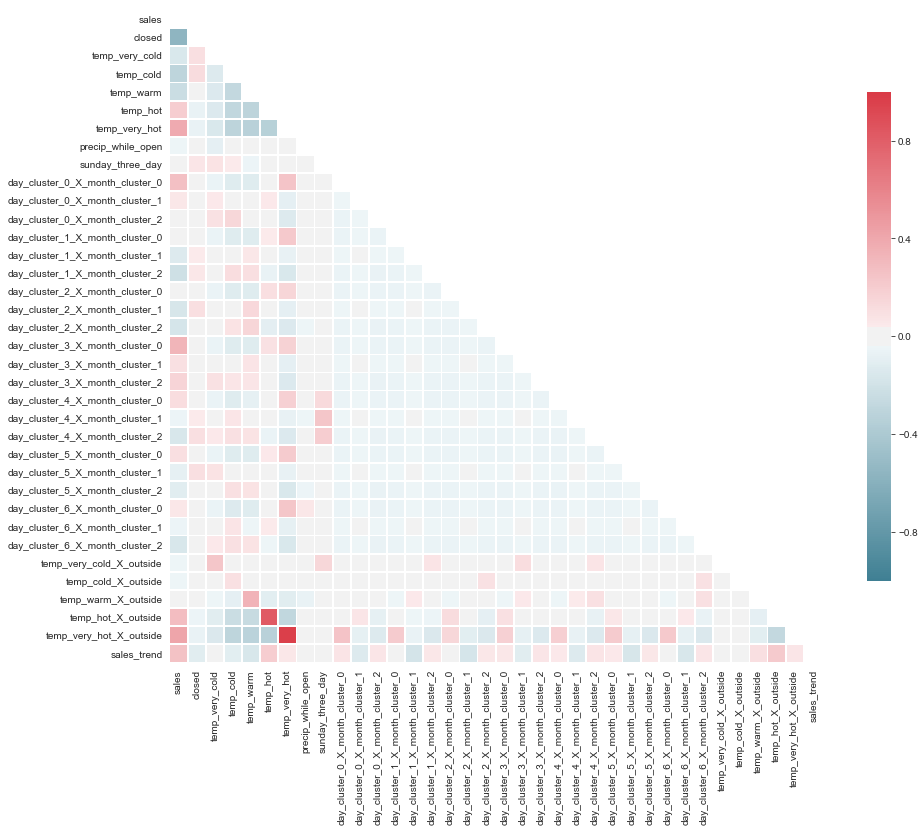

In [1282]:
def corr_chart(df):
    
    corr = dfx.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    sns.set_style('whitegrid')
    f, ax = plt.subplots(figsize=(16, 12))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.75, annot=False, cbar_kws={"shrink": .75});
    
corr_chart(dfx)

In [1250]:
# Download Current DataFrame to CSV
dfx.to_csv(f'rest_1_clean_engineered_{start_date}_to_{end_date}.csv')

## UPDATE SALES (ONLY ONCE)

In [1251]:
#current_sales_df = pd.read_csv(current_file)
#current_sales_df = current_sales_df.set_index('date')

In [1258]:
date = '2019-06-10'
sales = 18254.37
outside = 1
closed = 0

def add_sales_row(date, sales):
    
    df = pd.DataFrame({'sales': sales,
                      'outside': outside,
                      'closed': closed},
                       index=[date])
    
    return df

temp = add_sales_row(date, sales)

In [1259]:
def build_sales_df(current_sales_df, temp):
    
    current_sales_df = current_sales_df.append(temp)
    df['closed'] = 0
    
    return current_sales_df
    
current_sales_df = build_sales_df(current_sales_df, temp)

In [1283]:
# Import Most Recent DataFrame
df_before_features = pd.read_csv('csv_before_features.csv', index_col='date', parse_dates=True)

# Create New Weather DataFrame with Updated Data
new_date_start = '2019-06-10'
new_date_end = '2019-06-13'

def update_current_df(sales_df, df_before_features, new_date_start, new_end_date):
    
    sales_df = sales_df[new_date_start:]
    
    sales_df = sales_df.rename_axis(index = 'date')
    sales_df.index = pd.to_datetime(sales_df.index)

    ## Find Lat Long for Business
    lat, long = yelp_lat_long(search_business, location)

    ## Pull Weather Data / Forecast
    weather_df = build_weather_df(weather_call(new_date_start, new_date_end, lat, long))
    
    ## Parse, Clean, Engineer
    df = pd.merge(sales_df, weather_df, how='left', on='date')
    df, _ = one_hot_temp(df, temp_enc)
    df = pd.concat([df_before_features, df])
    df = sales_trend_engineering(feature_engineering(df))
    
    return df
    
current_df = update_current_df(current_sales_df, df_before_features, new_date_start, new_date_end)

Weather Location: Jupiter Disco


## Test / Train / Split

In [1284]:
def cv_split(df):
    
    features = dfx.drop(['sales'], axis=1)[days_fwd:]
    y = dfx['sales'][days_fwd:]
    
    return features, y

cv_features, cv_y = cv_split(current_df)

In [1285]:
def train_test_split(df):
    
    # Separate Target & Features
    y = df['sales']
    features = df.drop(['sales'], axis=1)
    
    # Test / Train / Split
    train_date_start = '2017-01-01'
    train_date_end = '2018-12-31'
    
    X_train = features[pd.to_datetime(train_date_start) + pd.DateOffset(days_fwd):train_date_end]
    X_test = features[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    y_train = y[pd.to_datetime(train_date_start) + pd.DateOffset(days_fwd):train_date_end]
    y_test = y[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    # Scale
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test = pd.DataFrame(X_test_scaled, columns=X_train.columns)
    
    print('Train set: ', len(X_train))
    print('Test set: ', len(X_test))
    
    return X_train, X_test, y_train, y_test, scaler
    
X_train, X_test, y_train, y_test, scaler = train_test_split(current_df)

Train set:  658
Test set:  162


In [1286]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class FeatureEngineer(BaseEstimator, TransformerMixin):
    
    def __init__(self, col):
        self.col = col
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.col]
    
    
cluster = Pipeline([
                    ('selector', FeatureEngineer(col='day_of_week')),
                    
])

### Linear Regression

In [1287]:
def linear_regression_model(X_train, y_train):
    
    lr = LinearRegression(fit_intercept=True)
    lr_rgr = lr.fit(X_train, y_train)
    
    return lr_rgr

In [1288]:
lr_rgr = linear_regression_model(X_train, y_train)

In [1289]:
def rgr_score(rgr, X_train, y_train, X_test, y_test, cv_features, cv_y):
    
    train_score = rgr.score(X_train, y_train)
    test_score = rgr.score(X_test, y_test)
    
    y_pred = rgr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print('Train R-Squared:  ', train_score)
    print('Test R-Squared:  ', test_score, '\n')
    
    print('Root Mean Squared Error: ', rmse, '\n')
    
    print('Cross Val Avg R-Squared: ',  \
          np.mean(cross_val_score(rgr, cv_features, cv_y, cv=10, scoring='r2')), '\n')
    
    print('Intercept:  ', rgr.intercept_, '\n')
    print('Coefficients:  \n')
    
    for index, col_name in enumerate(X_test.columns):
        print(col_name, ' --> ', rgr.coef_[index])

In [1290]:
rgr_score(lr_rgr, X_train, y_train, X_test, y_test, cv_features, cv_y)

Train R-Squared:   0.7866322592421163
Test R-Squared:   0.8105729982980985 

Root Mean Squared Error:  1361.8680549164546 

Cross Val Avg R-Squared:  0.6715008161440185 

Intercept:   409188081692245.6 

Coefficients:  

closed  -->  -14086.923089752525
temp_cold  -->  -508824400354243.5
temp_hot  -->  -508824400354012.7
temp_very_cold  -->  -508824400354313.1
temp_very_hot  -->  -508824400354607.0
temp_warm  -->  -508824400354156.1
precip_while_open  -->  -860.259401296018
sunday_three_day  -->  958.9994022409928
day_cluster_0_X_month_cluster_0  -->  99636318677574.6
day_cluster_0_X_month_cluster_1  -->  99636318677437.86
day_cluster_0_X_month_cluster_2  -->  99636318676691.6
day_cluster_1_X_month_cluster_0  -->  99636318674337.48
day_cluster_1_X_month_cluster_1  -->  99636318674966.27
day_cluster_1_X_month_cluster_2  -->  99636318674156.38
day_cluster_2_X_month_cluster_0  -->  99636318674577.78
day_cluster_2_X_month_cluster_1  -->  99636318674957.11
day_cluster_2_X_month_cluster_2  -

### Prediction Function

In [1291]:
outside = 1

def predict_df(clf, scaler, X_train, current_df, date_1, date_2):
    
    # Find Lat Long for Business
    lat, long = yelp_lat_long(search_business, location)
    
    # Pull Weather Data / Forecast
    weather_df = build_weather_df(weather_call(date_1, date_2, lat, long))
    day_of_week, apparent_temperature = weather_df['day_of_week'], weather_df['apparent_temperature']
    weather_df['outside'] = outside
    
    # One Hot Encode Temperature Using Fitted Encoder
    df, _ = one_hot_temp(weather_df, temp_enc)
    
    # Add Feature Engineering
    df = feature_engineering(df)
    
    # Add Sales Data for Sales Trend Engineering
    current_df = current_df['sales']
    df = pd.merge(df, current_df, on='date', how='left')
    df['sales'] = df['sales'].fillna(method='ffill')
    
    df = sales_trend_engineering(df)
    df = df.drop(['sales'], axis=1)
    
    # Ensure Column Parity
    missing_cols = set(X_train.columns) - set(df.columns)
    
    for c in missing_cols:
        df[c] = 0
        
    df = df[X_train.columns][-2:]
    
    # Scale Transform
    df_scaled = scaler.transform(df)
    df = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
    
    # Predict and Build Prediction DataFrame for Review
    pred_array = pd.DataFrame(clf.predict(df), index=df.index, columns=['sales'])
    pred_df = df[df.columns[(df != 0).any()]]
    pred_df = pd.concat([pred_df, day_of_week, apparent_temperature], axis=1)
    
    final_predict = pd.concat([pred_array, pred_df], axis=1)
    
    return final_predict

In [1292]:
tonight = predict_df(lr_rgr, scaler, X_train, current_df, pd.datetime.now().date() + pd.DateOffset(-days_fwd), pd.datetime.now().date())
tonight[-1:]

Weather Location: Jupiter Disco


,sales,temp_hot,day_cluster_5_X_month_cluster_0,day_cluster_6_X_month_cluster_0,temp_hot_X_outside,sales_trend,day_of_week,apparent_temperature
date,,,,,,,,
2019-06-13,17452.5625,1.0,1.0,0.0,1.0,0.441823,3,64.17


## Lasso

In [1315]:
def lasso_model(X_train, y_train):

    lassoReg = Lasso(fit_intercept=True, alpha=0.01)
    lasso_rgr = lassoReg.fit(X_train,y_train)

    return lasso_rgr

lasso_rgr = lasso_model(X_train, y_train)

In [1316]:
rgr_score(lasso_rgr, X_train, y_train, X_test, y_test, cv_features, cv_y)

Train R-Squared:   0.7866324229659422
Test R-Squared:   0.8105331999674009 

Root Mean Squared Error:  1362.0111106270701 

Cross Val Avg R-Squared:  0.6715435393604647 

Intercept:   13665.126179559855 

Coefficients:  

closed  -->  -14086.758005407899
temp_cold  -->  49.20312354841464
temp_hot  -->  279.56345996752515
temp_very_cold  -->  -20.16738990654508
temp_very_hot  -->  -311.83009690185906
temp_warm  -->  137.2528270254934
precip_while_open  -->  -860.2822329009451
sunday_three_day  -->  958.6848692852358
day_cluster_0_X_month_cluster_0  -->  1862.2886682860712
day_cluster_0_X_month_cluster_1  -->  1725.0487354391746
day_cluster_0_X_month_cluster_2  -->  979.3404687885666
day_cluster_1_X_month_cluster_0  -->  -1374.6642428033183
day_cluster_1_X_month_cluster_1  -->  -745.7056491516594
day_cluster_1_X_month_cluster_2  -->  -1555.6414028327256
day_cluster_2_X_month_cluster_0  -->  -1134.3943036731205
day_cluster_2_X_month_cluster_1  -->  -754.6309070794699
day_cluster_2_X_month

In [1317]:
tonight = predict_df(lasso_rgr, scaler, X_train, current_df, pd.datetime.now().date() + pd.DateOffset(-days_fwd), pd.datetime.now().date())
tonight[-1:]

Weather Location: Jupiter Disco


,sales,temp_hot,day_cluster_5_X_month_cluster_0,day_cluster_6_X_month_cluster_0,temp_hot_X_outside,sales_trend,day_of_week,apparent_temperature
date,,,,,,,,
2019-06-13,17451.802845,1.0,1.0,0.0,1.0,0.441823,3,64.17


### Random Forest Regression

In [1164]:
def rf_regression_model(X_train, y_train):
    
    rfr = RandomForestRegressor(max_depth= 60, 
                                max_features= 0.5, 
                                min_impurity_decrease= 0.0001, 
                                n_estimators= 1000)
    rfr_rgr = rfr.fit(X_train, y_train)
    
    return rfr_rgr

In [1165]:
rfr_rgr = rf_regression_model(X_train, y_train)

In [1166]:
def rfr_score(rgr, X_test, y_test, cv_features, cv_y):
    
    train_score = rgr.score(X_train, y_train)
    test_score = rgr.score(X_test, y_test)
    
    y_pred = rgr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print('Train R-Squared:  ', train_score)
    print('Test R-Squared:  ', test_score, '\n')
    
    print('Root Mean Squared Error: ', rmse, '\n')
    
    #print('Cross Val Avg R-Squared: ',  \
          #np.mean(cross_val_score(rgr, cv_features, cv_y, cv=10, scoring='r2')), '\n')
        
rfr_score(rfr_rgr, X_test, y_test, cv_features, cv_y) 

Train R-Squared:   0.9610822021304046
Test R-Squared:   0.7602093967630137 

Root Mean Squared Error:  1543.5739067973643 



### Random Forest Regression Prediction

In [1170]:
tonight = predict_df(rfr_rgr, scaler, X_train, current_df, pd.datetime.now().date() + pd.DateOffset(-days_fwd), pd.datetime.now().date())
tonight[-1:]

Weather Location: Jupiter Disco


,sales,temp_hot,sales_trend,day_cluster_5_X_month_cluster_0,day_cluster_6_X_month_cluster_0,temp_hot_X_outside,day_of_week,apparent_temperature
date,,,,,,,,
2019-06-13,16686.97584,1.0,0.775865,1.0,0.0,1.0,3,64.17


### Decision Tree Regressor

In [1222]:
def dt_regression_model(X_train, y_train):
    
    dt = DecisionTreeRegressor(max_depth= 7, 
                                max_features= 0.85,
                               random_state=0)
    
    dt_rgr = dt.fit(X_train, y_train)
    
    return dt_rgr

In [1223]:
dt_rgr = dt_regression_model(X_train, y_train)

In [1224]:
rfr_score(dt_rgr, X_test, y_test, cv_features, cv_y) 

Train R-Squared:   0.8013691645379242
Test R-Squared:   0.7586662808979667 

Root Mean Squared Error:  1548.5325948625039 



### Grid Search Helper Function

In [3990]:
def run_grid_search(rgr, params, X_train, y_train):
    
    cv = 5
    n_jobs = -1
    scoring = 'r2'
    
    grid = GridSearchCV(rgr, params, cv=cv, n_jobs=n_jobs, scoring=scoring, verbose=10)
    grid = grid.fit(X_train, y_train)
    
    best_grid_rgr = grid.best_estimator_
    
    print('Grid Search: ', rgr.__class__.__name__, '\n')
    print('Grid Search Best Score: ', grid.best_score_)
    print('Grid Search Best Params: ', grid.best_params_)
    print('Grid Search Best Estimator: ', grid.best_estimator_)

    return best_grid_rgr


In [3991]:
params = {
          'n_estimators': [500, 750, 1000, 1250],
          'max_depth': [30, 40, 50, 60, 70, 80],
          'min_impurity_decrease': [0.001, 0.0001],
          'max_features': ['auto', 0.25, 0.50, 0.75]
        }

best_grid_rgr = run_grid_search(rfr_rgr, params, X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

Grid Search:  RandomForestRegressor 

Grid Search Best Score:  0.6117064993199278
Grid Search Best Params:  {'max_depth': 40, 'max_features': 0.5, 'min_impurity_decrease': 0.001, 'n_estimators': 1000}
Grid Search Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.001, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [189]:
rfr_rgr.get_params().keys()

dict_keys(['bootstrap', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [591]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [592]:
dfx.head()

,sales,closed,temp_very_cold,temp_cold,temp_warm,temp_hot,temp_very_hot,precip_while_open,sunday_three_day,sales_trend,...,day_cluster_5_X_month_cluster_1,day_cluster_5_X_month_cluster_2,day_cluster_6_X_month_cluster_0,day_cluster_6_X_month_cluster_1,day_cluster_6_X_month_cluster_2,temp_very_cold_X_outside,temp_cold_X_outside,temp_warm_X_outside,temp_hot_X_outside,temp_very_hot_X_outside
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,12814.84,0,0.0,1.0,0.0,0.0,0.0,0,0,NaN,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
2017-01-03,12442.11,0,0.0,0.0,1.0,0.0,0.0,0,0,NaN,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
2017-01-04,11877.64,0,0.0,1.0,0.0,0.0,0.0,0,0,NaN,...,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0
2017-01-05,14057.79,0,0.0,1.0,0.0,0.0,0.0,0,0,NaN,...,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0
2017-01-06,14531.97,0,0.0,1.0,0.0,0.0,0.0,0,0,NaN,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0


In [734]:
f = ''

for c in dfx.columns:
    
    f += c + '+'
    
x = f[6:-1]

In [735]:
f='sales~' + x

model = ols(formula=f, data=dfx).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     91.38
Date:                Thu, 13 Jun 2019   Prob (F-statistic):          1.05e-240
Time:                        17:27:21   Log-Likelihood:                -6991.7
No. Observations:                 802   AIC:                         1.405e+04
Df Residuals:                     768   BIC:                         1.421e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        1.207e+04    102.469    117.831      0.000    1.19e+04    1.23e+04
closed                          -1.427e+04    507.533    -28.125      0.000   -1.53e+04   -1.33e+04
temp_very_cold                   2384.5812    244.623      9.748      0.000    1904.372    2864.790
temp_cold                        2391.1967    162.122     14.749      0.000    2072.941    2709.452
temp_warm                        2431.6279    145.899     16.666      0.000    2145.219    2718.037
temp_hot                         2661.6050    193.499     13.755      0.000    2281.755    3041.455
temp_very_hot                    2205.0126    426.257      5.173      0.000    1368.246    3041.779
precip_while_open                -616.4492    162.335     -3.797      0.000    -935.123    -297.775
sunday_three_day                 1513.6018    441.579      3.428      0.001     646.757    2380.447
sales_trend                         0.0265      0.005      5.115      0.000       0.016       0.037
day_cluster_0_X_month_cluster_0  2005.1037    228.212      8.786      0.000    1557.109    2453.098
day_cluster_0_X_month_cluster_1  2132.2954    372.363      5.726      0.000    1401.324    2863.266
day_cluster_0_X_month_cluster_2  1335.9571    265.121      5.039      0.000     815.510    1856.404
day_cluster_1_X_month_cluster_0  -542.8895    222.505     -2.440      0.015    -979.680    -106.099
day_cluster_1_X_month_cluster_1   536.7340    390.126      1.376      0.169    -229.107    1302.575
day_cluster_1_X_month_cluster_2  -680.3628    274.599     -2.478      0.013   -1219.416    -141.310
day_cluster_2_X_month_cluster_0   161.0884    219.425      0.734      0.463    -269.655     591.832
day_cluster_2_X_month_cluster_1   475.9945    368.387      1.292      0.197    -247.171    1199.160
day_cluster_2_X_month_cluster_2   -75.9090    281.905     -0.269      0.788    -629.304     477.486
day_cluster_3_X_month_cluster_0  -875.4366    213.368     -4.103      0.000   -1294.291    -456.583
day_cluster_3_X_month_cluster_1     0.9275    379.335      0.002      0.998    -743.728     745.583
day_cluster_3_X_month_cluster_2  -692.7907    283.179     -2.446      0.015   -1248.688    -136.894
day_cluster_4_X_month_cluster_0    24.6173    223.145      0.110      0.912    -413.429     462.663
day_cluster_4_X_month_cluster_1   939.6983    367.247      2.559      0.011     218.771    1660.626
day_cluster_4_X_month_cluster_2   -37.1090    271.573     -0.137      0.891    -570.222     496.004
day_cluster_5_X_month_cluster_0  3372.6739    224.056     15.053      0.000    2932.840    3812.508
day_cluster_5_X_month_cluster_1  2590.7815    376.461      6.882      0.000    1851.767    3329.796
day_cluster_5_X_month_cluster_2  3248.8733    275.451     11.795      0.000    2708